In [1]:
import numpy as np
from PIL import Image

from densecrf_np import util
from densecrf_np.densecrf import DenseCRF
from densecrf_np.params import DenseCRFParams
from matplotlib import pylab

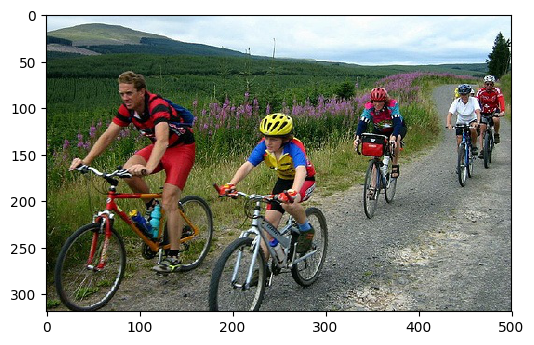

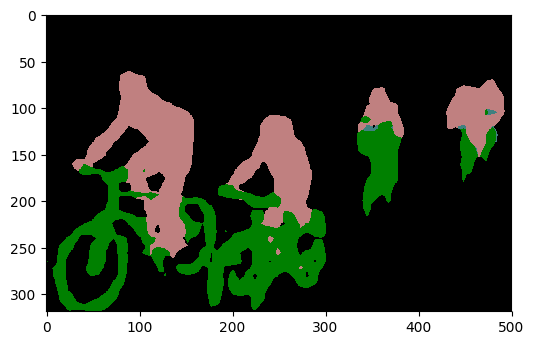

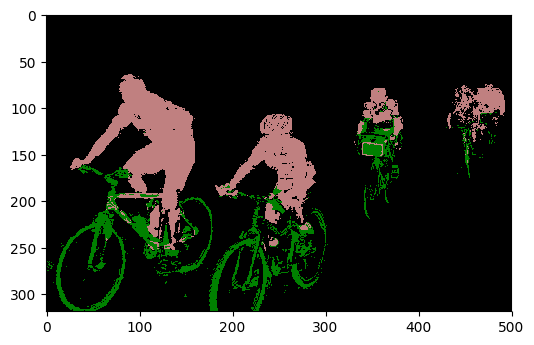

In [55]:

image_source = '../example/image.jpg'
# These unaries were obtained by running the FCN part of the model https://github.com/sadeepj/crfasrnn_keras
unary_logits_source = '../example/unary_logits.npy'
logits = np.load(unary_logits_source)

# Labels before the CRF
before_crf_labels = util.get_label_image(logits)

img = np.array(Image.open(image_source))
params = DenseCRFParams(spatial_ker_weight=0, bilateral_ker_weight=10.0)
crf = DenseCRF(img, params)
probs = crf.infer(logits, 5)

# Labels after the CRF
after_crf_labels = util.get_label_image(probs)

pylab.figure(dpi=100)
pylab.imshow(img)
pylab.figure(dpi=100)
pylab.imshow(before_crf_labels)
pylab.figure(dpi=100)
pylab.imshow(after_crf_labels)

{0, 2, 14, 15}


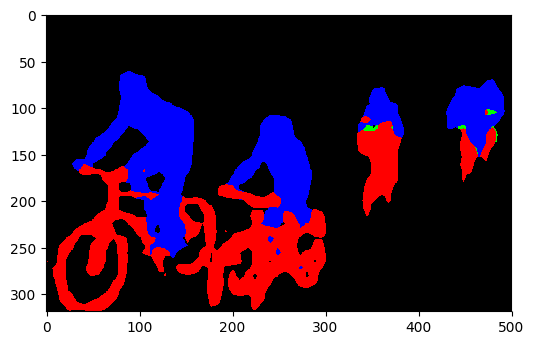

In [47]:
embeddings_map = np.random.rand(logits.shape[-1], 16)
U,s,Vt = np.linalg.svd(embeddings_map,full_matrices=False)
embeddings_map = U

# embeddings = np.dot(np.eye(21)[props.argmax(axis=-1)], embeddings_map).astype("float32") 
embeddings = np.eye(22)[logits.argmax(axis=-1)].astype("float32") 
print(set([np.argmax(x) for x in embeddings.reshape((-1, 22)).tolist()]))
# from densecrf_np.utils import softmax
# embeddings = softmax(logits[..., :16])
# embeddings[..., 3:] = 0
# embeddings = embeddings / np.linalg.norm(embeddings, 2, axis=2, keepdims=True)
pylab.figure(dpi=100)
pylab.imshow(embeddings[..., (2, 14, 15)])

In [56]:
from densecrf_np.pairwise import SpatialPairwise, BilateralPairwise
alpha, beta, gamma = params.alpha, params.beta, params.gamma
bp = BilateralPairwise(img, alpha, alpha, beta, beta, beta)
sp = SpatialPairwise(img, gamma, gamma)

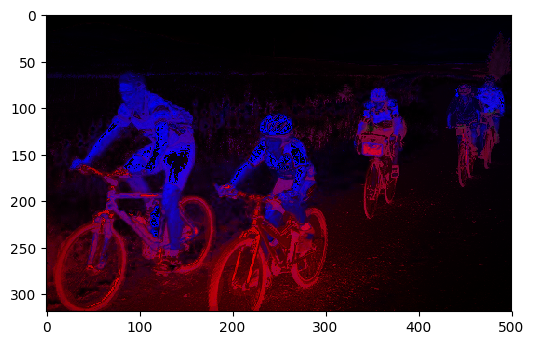

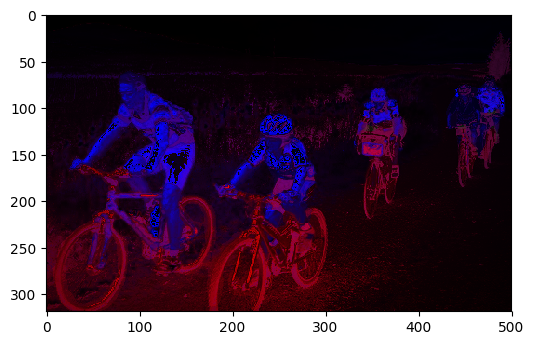

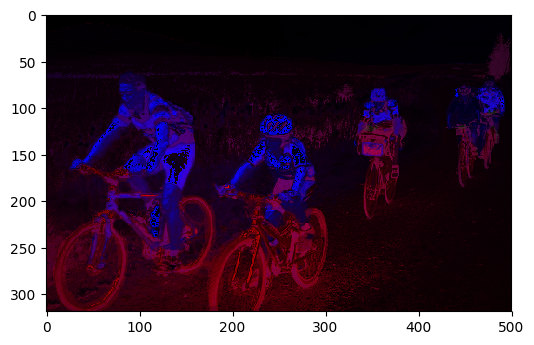

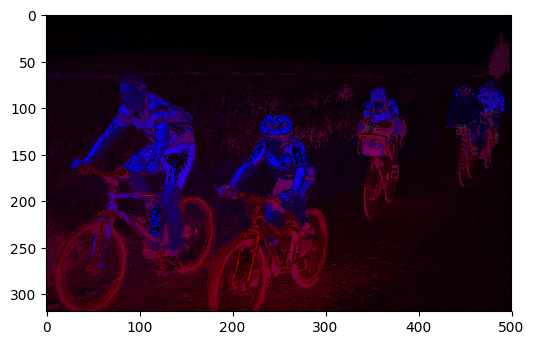

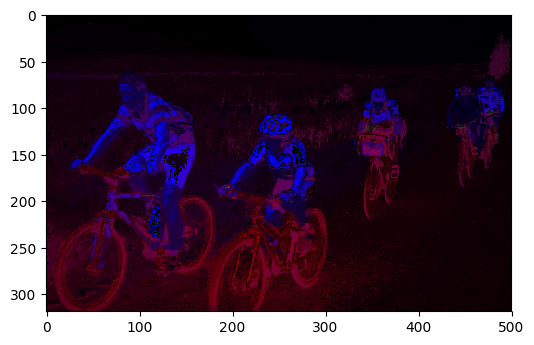

In [57]:
spatial_weight = params.spatial_ker_weight
bilateral_weight = params.bilateral_ker_weight
a = embeddings
diffs = []
n_iters = 5
for i in range(n_iters):
    new_a = (
        bp.apply(a) * bilateral_weight + 
        sp.apply(a) * spatial_weight + 
        embeddings
    ) / (bilateral_weight + spatial_weight + 1)
    diffs += [np.linalg.norm((a-new_a).reshape(-1, embeddings.shape[-1]), 2)]
    a = new_a
    pylab.figure(dpi=100)
    pylab.imshow(a[..., (2,14,15)] )


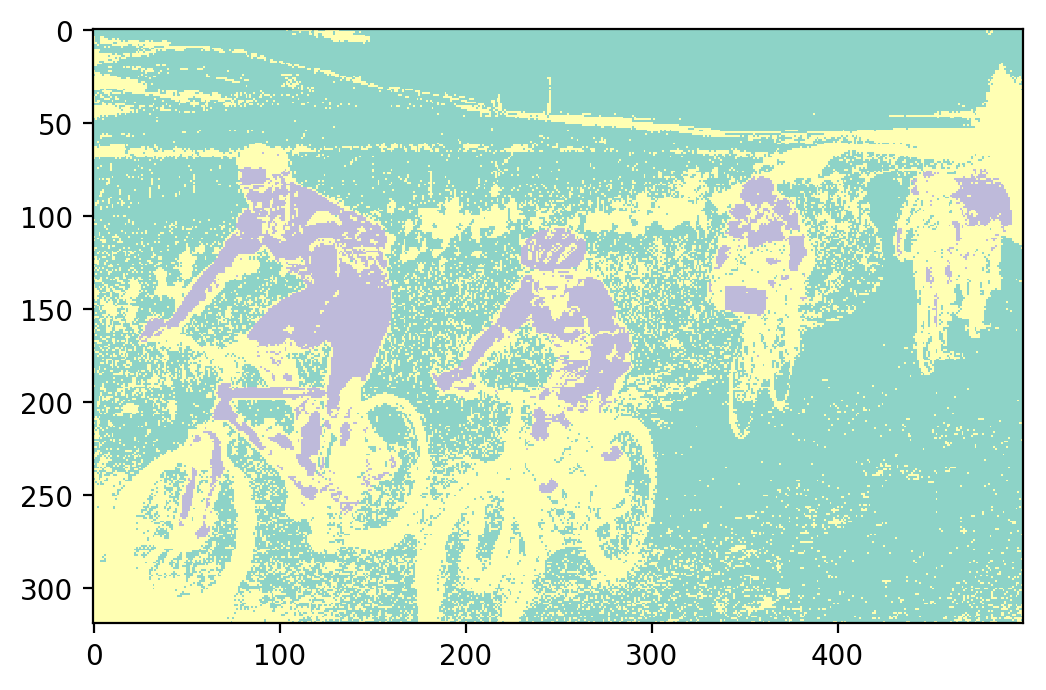

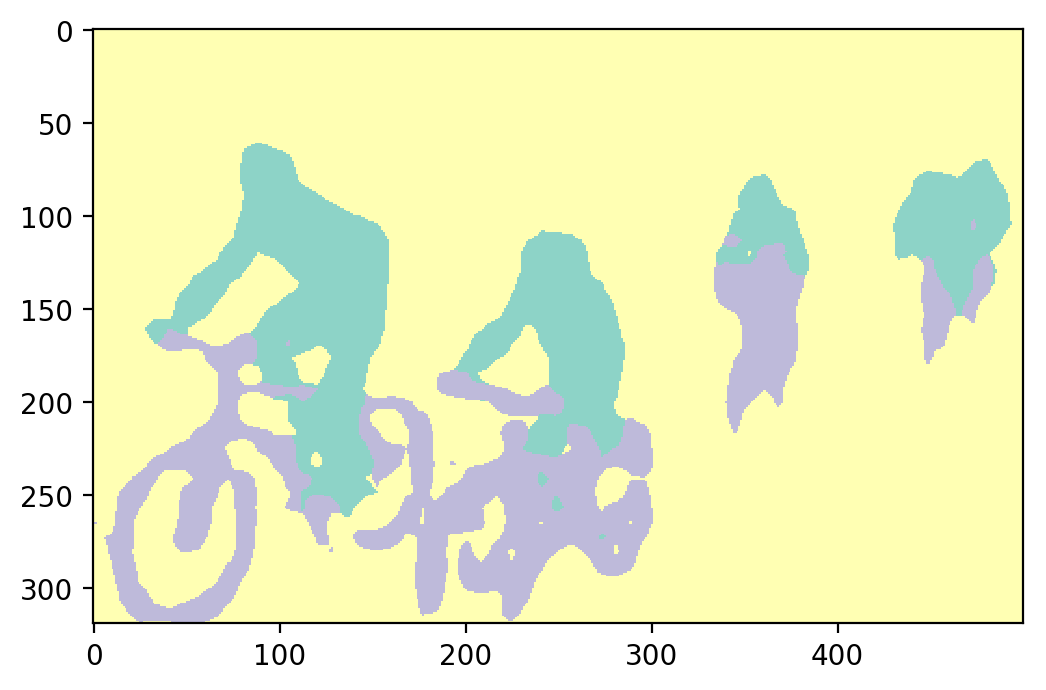

In [58]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=3).fit(a.reshape((-1, a.shape[-1])))
ret = clusters.predict(a.reshape((-1, a.shape[-1]))).reshape((a.shape[0], a.shape[1]))
pylab.figure(dpi=200)
pylab.imshow(pylab.cm.Set3(ret)[...,:3])

clusters = KMeans(n_clusters=3).fit(embeddings.reshape((-1, a.shape[-1])))
ret = clusters.predict(embeddings.reshape((-1, a.shape[-1]))).reshape((embeddings.shape[0], embeddings.shape[1]))
pylab.figure(dpi=200)
pylab.imshow(pylab.cm.Set3(ret)[...,:3])

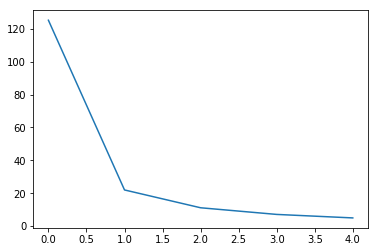

In [45]:
pylab.figure()
pylab.plot(diffs)